# 1. Texture

Let's start by writing a texture generator. The texture is a 1D structure with granules of varying size

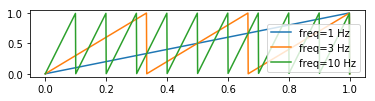

In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Generate a sawtooth function with a given period
def sawtooth(x, freq):
    return x*freq - np.floor(x*freq)

x = np.linspace(0, 1, 1000)
y1 = sawtooth(x, 1)
y2 = sawtooth(x, 3)
y3 = sawtooth(x, 10)


fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x, y1, label="freq=1 Hz")
ax.plot(x, y2, label="freq=3 Hz")
ax.plot(x, y3, label="freq=10 Hz")
ax.set_aspect(0.2)
ax.legend()
plt.show()

Let's upgrade the generator by allowing each tooth have randomly variable height and width

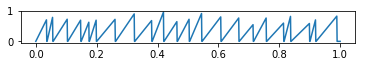

In [22]:
def oneTooth(nPoints, mag):
    x = np.linspace(0, 1, nPoints)
    return mag*sawtooth(x, nPoints)

def generateTeeth(numExtent, magExtent, lenStDev, nPoints):
    numTeeth = random.randint(numExtent[0], numExtent[1])
    magnitudes = np.random.uniform(magExtent[0], magExtent[1], numTeeth)
    lengths = np.random.uniform(1, 1+lenStDev, numTeeth)
    lengths *= nPoints / np.sum(lengths)
    rez = np.concatenate(tuple([oneTooth(int(l), m) for m, l in zip(magnitudes, lengths)]), axis=0)
    rez = np.concatenate((rez, np.zeros(nPoints-len(rez))))
    return rez
    
y = generateTeeth([20, 25], [0.5,1], 3, 1000)
x = np.linspace(0, 1, len(y))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_aspect(0.1)
ax.plot(x,y)
plt.show()

So we could generate two different textures

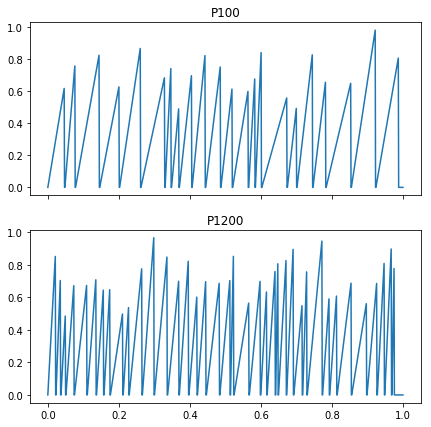

In [25]:
nPoints = 1000
x = np.linspace(0, 1, nPoints)
P100  = generateTeeth([20, 25], [0.5,1], 3, nPoints)
P1200 = generateTeeth([30, 40], [0.5,1], 5, nPoints)

fig, axs = plt.subplots(nrows=2, figsize=(7, 7), sharex=True)
axs[0].plot(x,P100)
axs[0].set_title('P100')
axs[1].plot(x,P1200)
axs[1].set_title('P1200')
plt.show()

# 2. Whisker Physics

Let us model the behaviour of a whisker moving across the texture. A few assumptions are necessary:
<ul>
<li> There is only one whisker
<li> The whisker has a base velocity $v_0$ that does not change during whisking
<li> The whisker has a second velocity on top of that, which varies due to stick-slip events
<li> The whisker experiences delays which are a function of the texture height gradient
</ul>

Firstly, let's agree that some deeper parts of the texture are never reached by the whisker, so they are equivalently non-existent

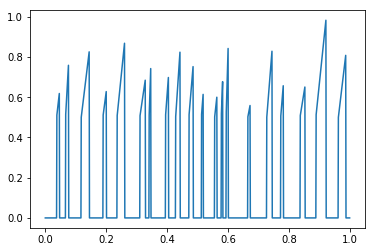

In [26]:
P100_proc = np.copy(P100)
P100_proc[P100_proc < 0.5] = 0
plt.plot(x, P100_proc)
plt.show()

Now, let's calculate the delay associated with visiting the given parts of the texture

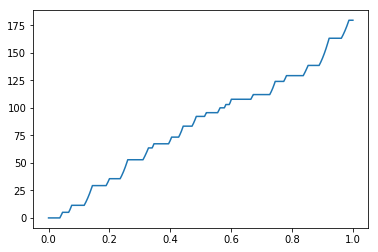

In [29]:
P100_delay = np.zeros(nPoints)
P100_delay[0] = P100_proc[0]
for i in range(1, nPoints):
    P100_delay[i] = P100_delay[i-1] + P100_proc[i]

plt.plot(x, P100_delay)
plt.show()

**Physics of the problem**

Base of the whisker is moving forwards with constant velocity

$\dot{x}_{base} = v_0$

When tip is stuck at the feature, tip does not move, but bending angle changes
<ul>
    <li> $\dot{x}_{tip} = 0$
    <li> $\dot{\alpha} = F(\alpha, h)$
</ul>
Tip stays stuck until a certain condition is satisfied
<ul>
    <li> $\alpha > G(h)$
</ul>
When the tip slips, it moves towards the next feature with high acceleration $\ddot{x}(t)$, decreasing angle $\alpha$
<ul>
    <li> $d\dot{x}_{tip} = \ddot{x}_{tip} dt = U(\alpha) dt$
    <li> $d\dot{\alpha} = \ddot{\alpha} dt = V(\alpha) dt$
</ul>

Let us do a bit of physics-motivated speculation. Firstly, a whisker is elastic, and thus can be modelled as a spring with a certain constant $k$

$U(\alpha) = $